In [1]:
#You might need to install obspy if you don't already have it (written with ObsPy 1.0.1)
#%sx pip install obspy

In [2]:
import obspy
import requests
import json

from obspy import read
import matplotlib.pyplot as plt

Function to convert a Stream to a (minimal) Waveform object

In [3]:
def irisTraceToWaveformJson(stream, evid, originTime, evLat, evLon):   
    obj = []
    for tr in stream.traces:        
        stat = tr.stats
        inventory = client.get_stations(network=stat.network, station=stat.station,
                                starttime=stat.starttime,
                                endtime=stat.endtime)  
        wave = {}
        event = {}
        event["eventId"] = evid
        event["originTime"] = originTime
        event["latitude"] = evLat
        event["longitude"] = evLon
        wave["event"] = event
        
        stream = {}
        station = {}
        station["networkName"] = stat.network
        station["stationName"] = stat.station
        station["latitude"] = inventory.networks[0].stations[0].latitude
        station["longitude"] = inventory.networks[0].stations[0].longitude
        stream["station"] = station;
        stream["channelName"] = stat.channel
        wave["stream"] = stream
        
        wave["beginTime"] = str(stat.starttime)
        wave["endTime"] = str(stat.endtime)
        wave["sampleRate"] = stat.sampling_rate
        wave["segment"] = tr.data.tolist()
        obj.append(wave)
    
    envelopeJob = {}
    envelopeJob["data"] = obj
    
    return envelopeJob

### Upload and run the calibration and envelope application services from the terminal before the rest of the notebook

java -jar envelope-application-1.0.*-runnable.jar

java -jar calibration-application-1.0.*-runnable.jar

Request data from NCEDC

In [4]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
#We could get data from IRIS but we just want Northern Cal data since thats our calibrated model's region
client = Client("http://service.ncedc.org/")

Here I am just picking an event that I know the calibration should be valid for given the stations in question

In [5]:
starttime = UTCDateTime("2007/10/31")
endtime = UTCDateTime("2007/11/01")
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=4.0, minlatitude=36.5, maxlatitude=38.5, minlongitude=-123, maxlongitude=-121)
print(cat)

1 Event(s) in Catalog:
2007-10-31T03:04:54.810000Z | +37.434, -121.774 | 5.45 Mw | manual


In [6]:
st = None

for event in cat.events:
    t = event.origins[0].time
    evid = str(event.resource_id).split("/")[3]
    evlat = event.origins[0].latitude
    evlon = event.origins[0].longitude
    stations = ["BRK", "BKS", "CVS", "MHC", "SAO", "WENL"]
    for sta in stations :
        ste = client.get_waveforms("BK", sta, "*", "BHE", t - 500, t + 3000, attach_response=True)
        stn = client.get_waveforms("BK", sta, "*", "BHN", t - 500, t + 3000, attach_response=True)

        if (st == None):
            st = ste + stn
        else:
            st = st + ste + stn    

print(st)

12 Trace(s) in Stream:
BK.BRK..BHE  | 2007-10-31T02:56:34.835645Z - 2007-10-31T03:54:54.810645Z | 40.0 Hz, 140000 samples
BK.BRK..BHN  | 2007-10-31T02:56:34.835645Z - 2007-10-31T03:54:54.810645Z | 40.0 Hz, 140000 samples
BK.BKS..BHE  | 2007-10-31T02:56:34.823338Z - 2007-10-31T03:54:54.798338Z | 40.0 Hz, 140000 samples
BK.BKS..BHN  | 2007-10-31T02:56:34.823338Z - 2007-10-31T03:54:54.798338Z | 40.0 Hz, 140000 samples
BK.CVS..BHE  | 2007-10-31T02:56:34.837466Z - 2007-10-31T03:54:54.812466Z | 40.0 Hz, 140000 samples
BK.CVS..BHN  | 2007-10-31T02:56:34.837465Z - 2007-10-31T03:54:54.812465Z | 40.0 Hz, 140000 samples
BK.MHC..BHE  | 2007-10-31T02:56:34.835642Z - 2007-10-31T03:54:54.810642Z | 40.0 Hz, 140000 samples
BK.MHC..BHN  | 2007-10-31T02:56:34.835642Z - 2007-10-31T03:54:54.810642Z | 40.0 Hz, 140000 samples
BK.SAO..BHE  | 2007-10-31T02:56:34.823144Z - 2007-10-31T03:54:54.798144Z | 40.0 Hz, 140000 samples
BK.SAO..BHN  | 2007-10-31T02:56:34.823144Z - 2007-10-31T03:54:54.798144Z | 40.0 Hz, 14

Convert the ObsPy Stream into Waveform JSON

In [7]:
waveData = irisTraceToWaveformJson(st, evid, str(t), evlat, evlon)

The service uses self signed certs, unless you specify ones to use, so for this example we just ignore the ssl verifcation errors. 

### Do not do this if you are using anything not on localhost in this notebook!

In [8]:
requests.packages.urllib3.disable_warnings()

Post the frequency band based model parameters

In [9]:
with open("norcal_bands.json") as bands:
    norcal_bands = json.load(bands)
    r = requests.post('https://127.0.0.1:53921/api/v1/params/shared-fb-parameters/batch', json=norcal_bands, verify=False)
    print(r.status_code)
    print(r.text)

200



Post the site corrections to the service for northern california (obtained from running the calibration service, not shown here).

In [10]:
with open("norcal_site.json") as corrections:
    norcal_corrections = json.load(corrections)
    r = requests.post('https://127.0.0.1:53921/api/v1/params/site-fb-parameters/batch', json=norcal_corrections, verify=False)
    print(r.status_code)

200


Post the data to the envelopes service and decode the resulting stacks. Note that I am not posting envelope bands in this request and just relying on the default configuration so this will output fewer bands than we actually calibrated against. In practice I would want to submit the bands with the job to get the full spectra I have calibrations for (see EnvelopeJob for the format for that).

In [11]:
r = requests.post('https://127.0.0.1:53922/api/v1/envelopes/create/batch-stacks-only/10000', json=waveData, verify=False)
print(r.status_code)
envData = json.loads(r.text)["resultPayload"]

200


Post data to Mw endpoint and receive the measurements back

In [12]:
r = requests.post('https://127.0.0.1:53921/api/v1/measurement/measure-mws-from-stacks/true', json=envData, verify=False)
print(r.status_code)
eventMws = json.loads(r.text)

200


In [47]:
print(list(eventMws["measuredMwDetails"].values())[0])

{'eventId': '40204628', 'mw': 5.405543565488166, 'refMw': None, 'apparentStressInMpa': 0.5181555647743256, 'refApparentStressInMpa': None, 'dataCount': 60, 'latitude': 37.4325, 'longitude': -121.7756667, 'datetime': '2007-10-31T03:04:54.820Z'}


Plot the returned Mws vs the NCEDC Mws

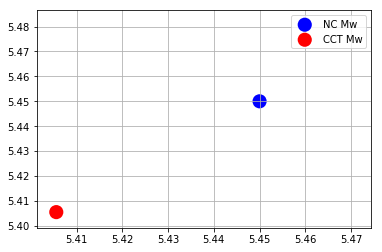

In [49]:
fig, ax = plt.subplots()
x1 = [cat.events[0].magnitudes[0].mag]
x2 = [list(eventMws["measuredMwDetails"].values())[0]["mw"]]
scale = 200.0

ax.scatter(x1,x1, c='blue', s=scale, label='NC Mw',
           alpha=1, edgecolors='none')

ax.scatter(x2,x2, c='red', s=scale, label='CCT Mw',
           alpha=1, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()